### Visualizing weather data

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

from pyspark import SparkContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

import numpy as np
from lib.numpy_pack import packArray,unpackArray
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

Populating the interactive namespace from numpy and matplotlib


In [39]:
import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

### Read weather data for state

In [3]:
state='NY'
data_dir='../../Data/Weather'

tarname=state+'.tgz'
parquet=state+'.parquet'

!rm -rf $data_dir/$tarname

command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/%s > %s/%s"%(tarname,data_dir,tarname)
print(command)
!$command
!ls -lh $data_dir/$tarname

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/NY.tgz > ../../Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.1M  100 22.1M    0     0  5381k      0  0:00:04  0:00:04 --:--:-- 5381k
-rw-r--r--  1 yoavfreund  staff    22M Apr  1 19:54 ../../Data/Weather/NY.tgz


In [15]:
cur_dir,=!pwd
%cd $data_dir
!tar -xzf $tarname
!du ./$parquet
%cd $cur_dir


weather_df=sqlContext.read.parquet(data_dir+'/'+parquet)
weather_df=weather_df.drop('State')
print(weather_df.count())
weather_df.show(5)

/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Data/Weather
56480	./NY.parquet
/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Section2-PCA/PCA
84199
+-----------+-----------+----+--------------------+
|    Station|Measurement|Year|              Values|
+-----------+-----------+----+--------------------+
|USC00303452|       PRCP|1903|[00 7E 00 7E 00 7...|
|USC00303452|       PRCP|1904|[00 00 28 5B 00 0...|
|USC00303452|       PRCP|1905|[00 00 60 56 60 5...|
|USC00303452|       PRCP|1906|[00 00 00 00 00 0...|
|USC00303452|       PRCP|1907|[00 00 00 00 60 5...|
+-----------+-----------+----+--------------------+
only showing top 5 rows



### read statistics information for state.

In [16]:
!aws s3 ls mas-dse-open/Weather/by_state/ | grep STAT

2018-04-01 14:32:56   14948011 STAT_NY.pickle.gz
2018-03-18 20:33:54   11717259 STAT_RI.pickle.gz


In [17]:
#read statistics
filename='STAT_%s.pickle'%state
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/%s.gz > %s/%s.gz"%(filename,data_dir,filename)
print(command)
!$command

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/STAT_NY.pickle.gz > ../../Data/Weather/STAT_NY.pickle.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.2M  100 14.2M    0     0  4733k      0  0:00:03  0:00:03 --:--:-- 4734k


In [18]:
gzpath='%s/%s.gz'%(data_dir,filename)
print(gzpath)
!ls -l $gzpath
!gunzip -f $gzpath
STAT,STAT_Descriptions = load(open(data_dir+'/'+filename,'rb'))
print('keys from STAT=',STAT.keys())

../../Data/Weather/STAT_NY.pickle.gz
-rw-r--r--  1 yoavfreund  staff  14948011 Apr  1 19:57 ../../Data/Weather/STAT_NY.pickle.gz
keys from STAT= dict_keys(['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS'])


### Read information about US weather stations.

In [19]:
filename='US_stations.tsv.gz'
command="curl https://mas-dse-open.s3.amazonaws.com/Weather/Info/%s > %s/%s"%(filename,data_dir,filename)
print(command)
!$command
filename_no_gz = filename[:-3]
!gunzip -f $data_dir/$filename
!ls -lh $data_dir/US_stations*

curl https://mas-dse-open.s3.amazonaws.com/Weather/Info/US_stations.tsv.gz > ../../Data/Weather/US_stations.tsv.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  320k  100  320k    0     0   408k      0 --:--:-- --:--:-- --:--:--  408k
-rw-r--r--  1 yoavfreund  staff   714K Apr  1 19:58 ../../Data/Weather/US_stations.tsv


In [20]:
#read csv into pandas dataframe
PATH='%s/%s'%(data_dir,filename_no_gz)
print(PATH)
stations=pd.read_csv(PATH,sep='\t')

../../Data/Weather/US_stations.tsv


In [21]:
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType, FloatType

schema = StructType([StructField("Station", StringType(), False),
                     StructField("Dist_coast", FloatType(), False),
                     StructField("Latitude", FloatType(), False),
                     StructField("Longitude", FloatType(), False),
                     StructField("Elevation", FloatType(), False),
                     StructField("State", StringType(), True),                  
                     StructField("Name", StringType(), False)])                


In [22]:
stations_df = sqlContext.createDataFrame(stations,schema)
stations_df.show(5)

+-----------+----------+--------+---------+---------+-----+----------------+
|    Station|Dist_coast|Latitude|Longitude|Elevation|State|            Name|
+-----------+----------+--------+---------+---------+-----+----------------+
|USC00044534|   107.655| 36.0042|  -119.96|     73.2|   CA|  KETTLEMAN CITY|
|USC00356784|   0.61097| 42.7519|-124.5011|     12.8|   OR|PORT ORFORD NO 2|
|USC00243581|   1316.54| 47.1064|-104.7183|    632.8|   MT|        GLENDIVE|
|USC00205601|   685.501|   41.75| -84.2167|    247.2|   MI|         MORENCI|
|CA005010480|   908.271|  49.917|   -99.95|    409.0|  NaN| BRANDON AIRPORT|
+-----------+----------+--------+---------+---------+-----+----------------+
only showing top 5 rows



In [67]:
!ls $data_dir

NY.parquet       Old              US_stations.tsv
NY.tgz           STAT_NY.pickle   stations.parquet


In [66]:
stations_df.write.parquet(data_dir+'/stations.parquet')

In [23]:
jdf=weather_df.join(stations_df,on='Station',how='left')
jdf.show(4)

+-----------+-----------+----+--------------------+----------+--------+---------+---------+-----+-------+
|    Station|Measurement|Year|              Values|Dist_coast|Latitude|Longitude|Elevation|State|   Name|
+-----------+-----------+----+--------------------+----------+--------+---------+---------+-----+-------+
|USC00303955|       PRCP|1992|[00 7E 00 7E 00 7...|   362.277| 42.7919| -77.5136|    243.8|   NY|HONEOYE|
|USC00303955|       PRCP|1993|[00 00 00 00 00 0...|   362.277| 42.7919| -77.5136|    243.8|   NY|HONEOYE|
|USC00303955|       PRCP|1994|[00 00 00 00 00 0...|   362.277| 42.7919| -77.5136|    243.8|   NY|HONEOYE|
|USC00303955|       PRCP|1995|[00 4F 00 49 80 4...|   362.277| 42.7919| -77.5136|    243.8|   NY|HONEOYE|
+-----------+-----------+----+--------------------+----------+--------+---------+---------+-----+-------+
only showing top 4 rows



In [24]:
jdf.select(['Station','Measurement','Year','Name']).show(4)

+-----------+-----------+----+-------+
|    Station|Measurement|Year|   Name|
+-----------+-----------+----+-------+
|USC00303955|       PRCP|1992|HONEOYE|
|USC00303955|       PRCP|1993|HONEOYE|
|USC00303955|       PRCP|1994|HONEOYE|
|USC00303955|       PRCP|1995|HONEOYE|
+-----------+-----------+----+-------+
only showing top 4 rows



In [25]:
sqlContext.registerDataFrameAsTable(jdf,'jdf')

In [26]:
#find the stations in NY with the most measurements.
sqlContext.sql('select Name,count(Name) as count from jdf GROUP BY Name ORDER BY count DESC').show(5)

+--------------------+-----+
|                Name|count|
+--------------------+-----+
|     SETAUKET STRONG|  719|
|NEW YORK CNTRL PK...|  715|
|            LOWVILLE|  705|
|              ELMIRA|  704|
|            ANGELICA|  703|
+--------------------+-----+
only showing top 5 rows



In [27]:
#find how many measurements of each type for a particlar station
stat='ELMIRA'
Query="""
SELECT Measurement,count(Measurement) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Measurement
"""%stat
sqlContext.sql(Query).show()

+-----------+-----+
|Measurement|count|
+-----------+-----+
|       TMIN|  120|
|       TOBS|  113|
|       TMAX|  120|
|       SNOW|  121|
|       SNWD|  109|
|       PRCP|  121|
+-----------+-----+



In [28]:
#find year with all 6 measurements
Query="""
SELECT Year,count(Year) as count 
FROM jdf 
WHERE Name='%s' 
GROUP BY Year
ORDER BY count DESC
"""%stat
sqlContext.sql(Query).show(5)

+----+-----+
|Year|count|
+----+-----+
|1924|    6|
|1959|    6|
|1977|    6|
|1990|    6|
|1975|    6|
+----+-----+
only showing top 5 rows



In [29]:
# get all measurements for a particular year and a particular station
year=2007
Query="""
SELECT *
FROM jdf 
WHERE Name='%s' 
and Year=%d
"""%(stat,year)
pandas_df=sqlContext.sql(Query).toPandas()
pandas_df=pandas_df.set_index('Measurement')
pandas_df

,Station,Year,Values,Dist_coast,Latitude,Longitude,Elevation,State,Name
Measurement,,,,,,,,,
PRCP,USC00302610,2007,"[0, 69, 0, 0, 0, 0, 0, 72, 128, 86, 0, 66, 112...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNOW,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
SNWD,USC00302610,2007,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TMAX,USC00302610,2007,"[160, 86, 160, 86, 160, 86, 40, 88, 128, 88, 9...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TMIN,USC00302610,2007,"[0, 0, 128, 209, 0, 207, 0, 0, 128, 84, 128, 7...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA
TOBS,USC00302610,2007,"[0, 0, 64, 204, 0, 0, 224, 85, 160, 87, 64, 76...",272.682007,42.099701,-76.8358,288.600006,NY,ELMIRA


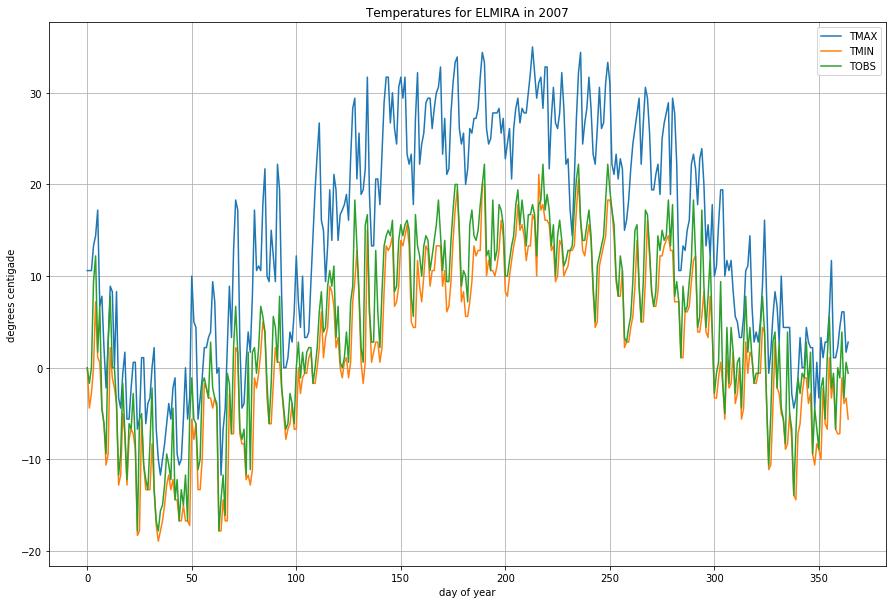

In [30]:
_tmax=unpackArray(pandas_df.loc['TMAX','Values'],np.float16)/10.
_tmin=unpackArray(pandas_df.loc['TMIN','Values'],np.float16)/10.
_tobs=unpackArray(pandas_df.loc['TOBS','Values'],np.float16)/10.
figure(figsize=(15,10))
plot(_tmax,label='TMAX');
plot(_tmin,label='TMIN');
plot(_tobs,label='TOBS');
xlabel('day of year')
ylabel('degrees centigade')
title('Temperatures for %s in %d'%(stat,year))
legend()
grid()

### Script for plotting yearly plots

In [31]:
T=np.stack([_tmin,_tmax,_tobs])

In [ ]:
# %load lib/YearPlotter.py
from datetime import date
from numpy import shape
from matplotlib.dates import MonthLocator, DateFormatter
class YearPlotter:
    def __init__(self):
        start=365*1+1
        self.dates=[date.fromordinal(i) for i in range(start,start+365)]
        self.monthsFmt = DateFormatter("%b")
        self.months = MonthLocator(range(1, 13), bymonthday=1, interval=3)
        #self.i=0

    def plot(self,T,fig,ax,label='',labels=None,title=None):
        #print(self.i,'fig=',fig,'ax=',ax)
        #self.i+=1
        shp=shape(T)
        if shp[0] != 365:
            raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
        if len(shp)==1:
            #print('one')
            ax.plot(self.dates,T,label=label);
        else:
            #print('more than 1')
            if labels is None:
                labels=[str(i) for i in range(shp[1])]
            for i in range(shp[1]):
                ax.plot(self.dates,T[:,i],label=labels[i])
        ax.xaxis.set_major_locator(self.months)
        ax.xaxis.set_major_formatter(self.monthsFmt)
        if not title is None:
            ax.set_title(title)
        #rotate and align the tick labels so they look better
        fig.autofmt_xdate()
        ax.grid()
        ax.legend()
       

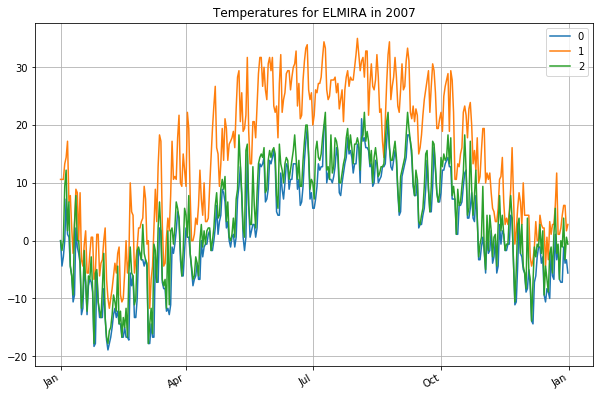

In [33]:
from lib.YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T.transpose(),fig,ax,title='Temperatures for %s in %d'%(stat,year));
plt.savefig('percipitation.png')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [45]:
from lib.MultiPlot import *
YP=YearPlotter()
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m,label=m)
    

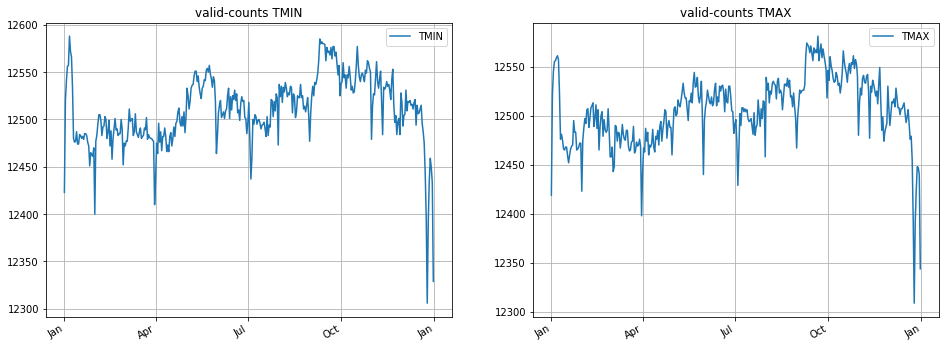

In [46]:
plot_pair(['TMIN','TMAX'],plot_valid)

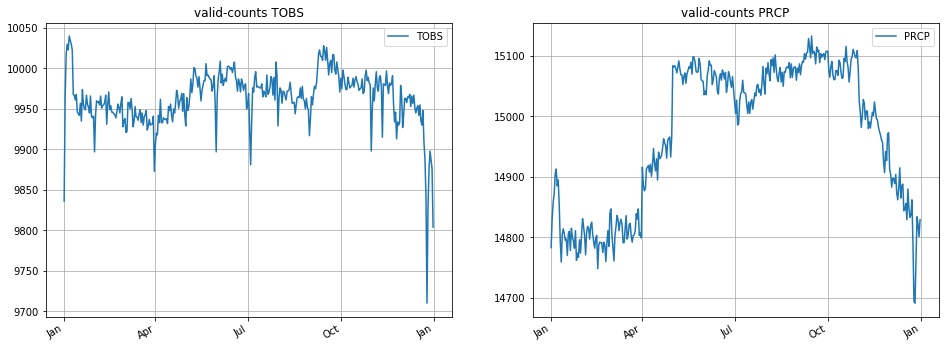

In [47]:
plot_pair(['TOBS','PRCP'],plot_valid)

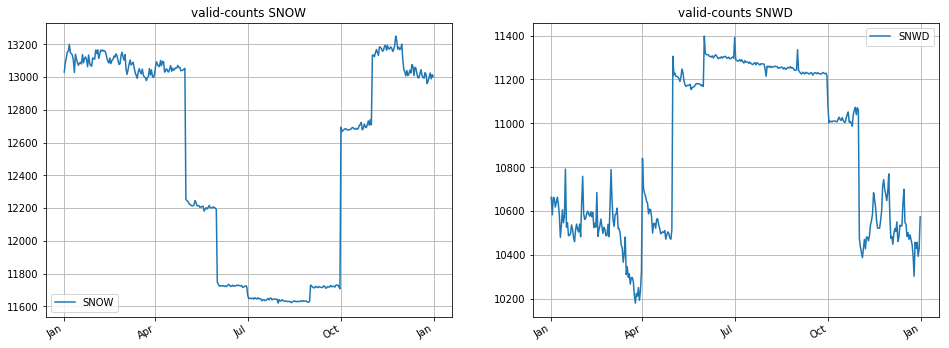

In [48]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [49]:
def plot_mean_std(m,fig,axis):
    scale=1.
    temps=['TMIN','TMAX','TOBS']
    percipitation=['PRCP','SNOW','SNWD']
    _labels=['mean+std','mean','mean-std']
    if (m in temps or m=='PRCP'):
        scale=10.
    mean=STAT[m]['Mean']/scale
    std=np.sqrt(STAT[m]['Var'])/scale
    graphs=np.vstack([mean+std,mean,mean-std]).transpose()
    YP.plot(graphs,fig,axis,labels=_labels,title='Mean+-std   '+m)
    if (m in temps):
        axis.set_ylabel('Degrees Celsius')
    if (m in percipitation):
        axis.set_ylabel('millimeter')



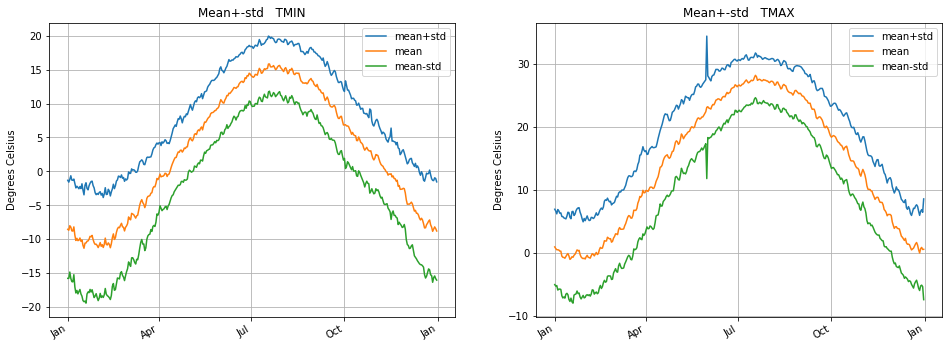

In [50]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

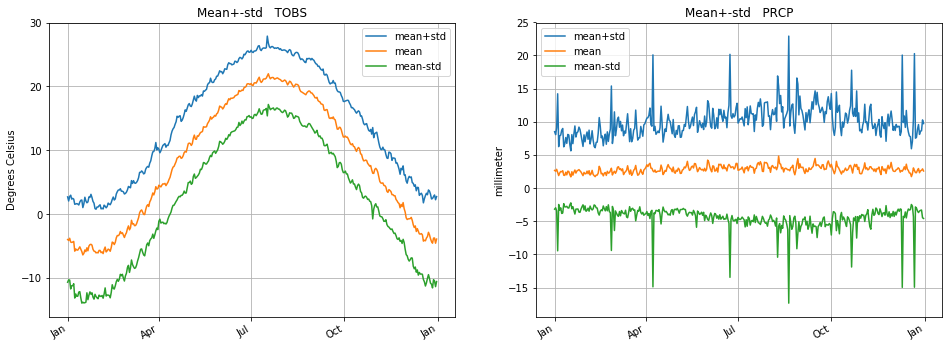

In [51]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

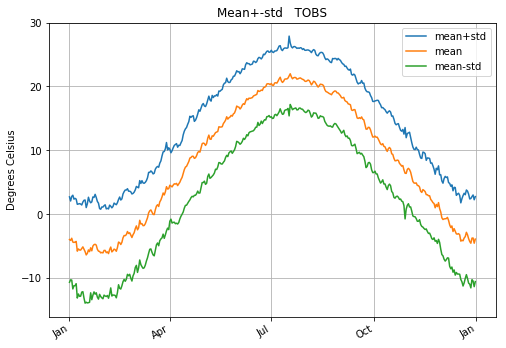

In [52]:
plot_single('TOBS',plot_mean_std,'r_figures/TOBS.png')

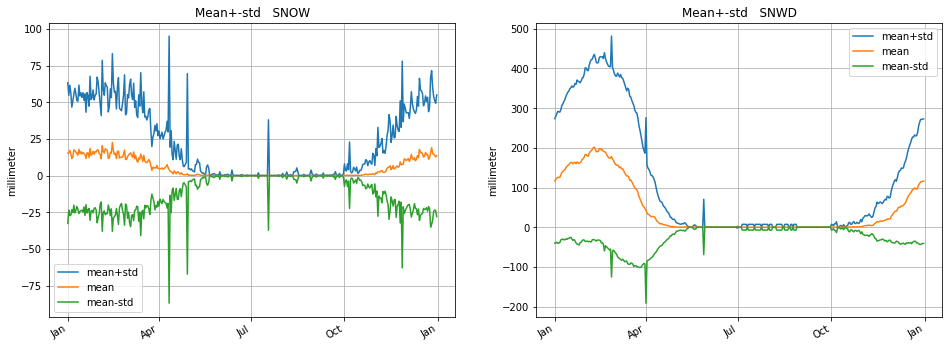

In [53]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

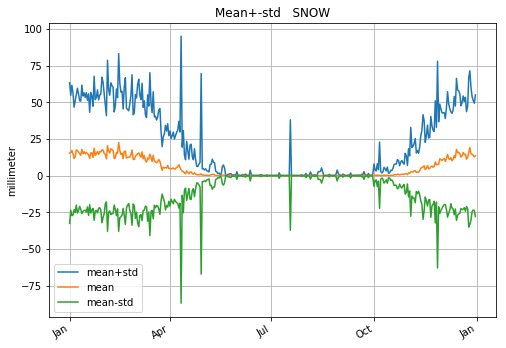

In [54]:
plot_single('SNOW',plot_mean_std,'r_figures/SNOW.png')

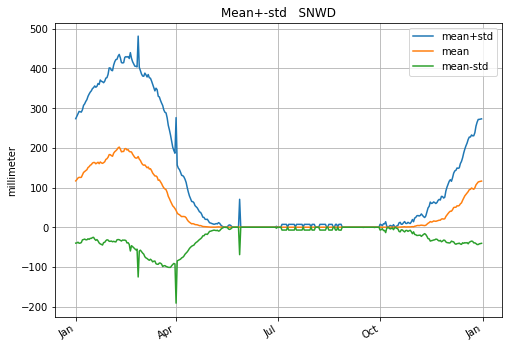

In [55]:
plot_single('SNWD',plot_mean_std,'r_figures/SNWD.png')

### plotting top 3 eigenvectors

In [56]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

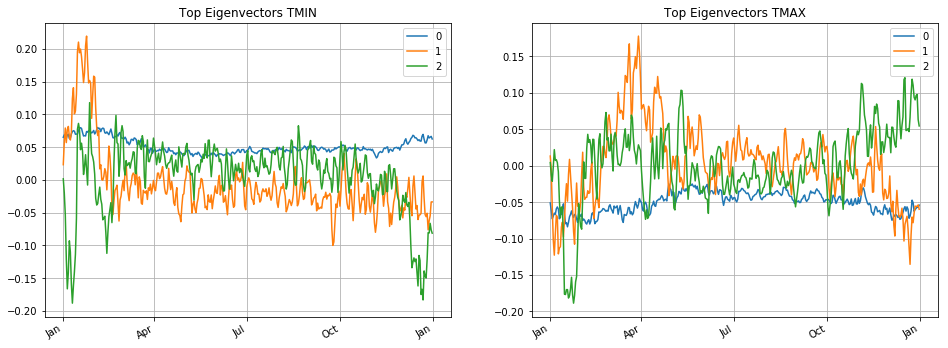

In [57]:
plot_pair(['TMIN','TMAX'],plot_eigen)

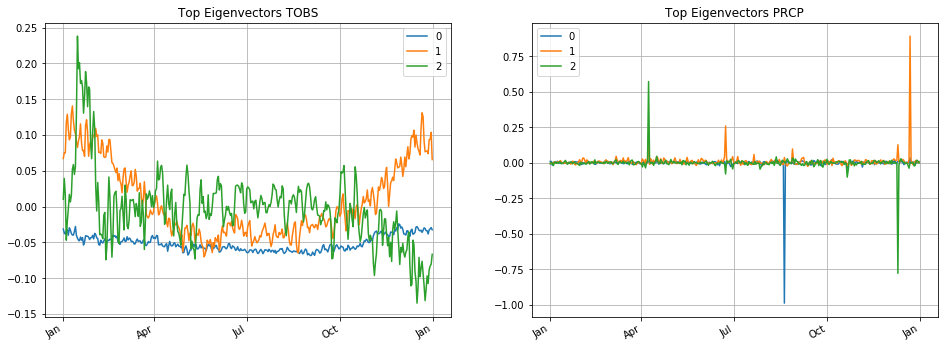

In [58]:
plot_pair(['TOBS','PRCP'],plot_eigen)

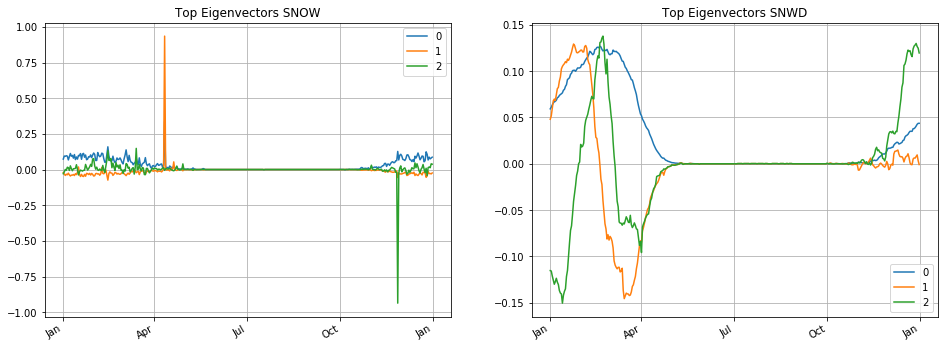

In [59]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [60]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    L=([0,]+list(cumsum(EV[:k])))/sum(EV)
    #print m,L
    plot(L)
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

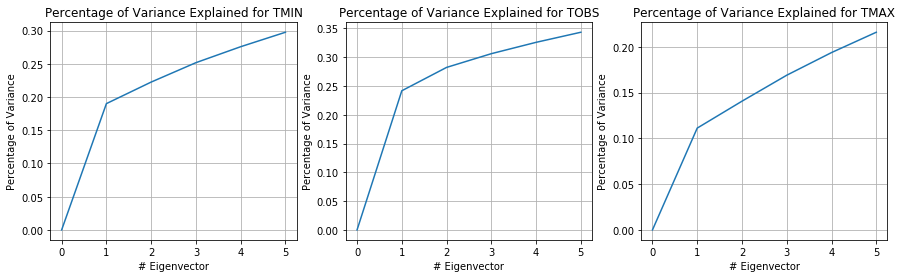

In [61]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1
f.savefig('r_figures/VarExplained1.png')

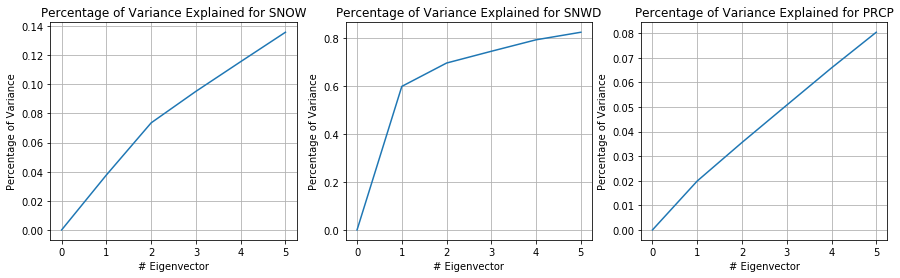

In [62]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig('r_figures/VarExplained2.png')

In [63]:
#sc.stop()